In [ ]:
# Environment Setup for Adaptive RAG
# Load API keys from .env file for secure credential management
from dotenv import load_dotenv
import os

load_dotenv()

# Get API keys for both OpenAI (for LLM operations) and Tavily (for web search)
# Adaptive RAG uses both local retrieval and web search capabilities
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

# Validate that required API keys are present
# Both keys are essential for Adaptive RAG's multi-source retrieval strategy
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file.")
if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY not found in .env file.")

In [ ]:
# Import Libraries for Adaptive RAG Implementation
# Adaptive RAG intelligently routes between local and web search based on query analysis

# Core data handling and evaluation libraries
import pandas as pd
import evaluate  # For computing evaluation metrics
from transformers import pipeline  # For transformer model pipelines

# LangChain components for document processing and retrieval
from langchain_huggingface import HuggingFaceEmbeddings  # Text embeddings for vector search
from langchain.text_splitter import CharacterTextSplitter  # Document chunking
from langchain_community.vectorstores import FAISS  # Vector database for local retrieval
from langchain_community.document_loaders import DataFrameLoader  # Load documents from DataFrame

# LangChain core components for building adaptive workflows
from langchain_core.prompts import ChatPromptTemplate  # Structured prompt templates
from langchain_core.runnables import RunnableParallel, RunnablePassthrough  # Chain composition
from langchain_core.output_parsers import StrOutputParser  # Response parsing
from langchain import hub  # Access to LangChain prompt hub
from langchain_openai import ChatOpenAI  # OpenAI LLM integration

# Additional utilities for model operations
import os
import getpass
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from langchain.llms import HuggingFaceHub

In [ ]:
# Create Local Document Retriever for Adaptive RAG
# This function sets up the local knowledge base that Adaptive RAG will use
# as one of its retrieval sources (the other being web search)
def get_reteriver() : 
    import pandas as pd
    
    # Load UCSC-specific documents from CSV
    # This serves as our local knowledge base for university-specific queries
    ucsc_passage_df = pd.read_csv("passage.csv")
    
    # Convert DataFrame to LangChain document format
    # Each row becomes a Document object with the passage content
    ucsc_passge_data_loader = DataFrameLoader(ucsc_passage_df, page_content_column="passage")
    ucsc_passage_data = ucsc_passge_data_loader.load()
    
    # Split documents into smaller chunks for more precise retrieval
    # Small chunks (200 chars) with overlap (50 chars) ensure good coverage
    text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=50)
    docs = text_splitter.split_documents(ucsc_passage_data)
    
    # Create embeddings using HuggingFace sentence transformers
    # These convert text to vectors for semantic similarity search
    embeddings = HuggingFaceEmbeddings()
    
    # Build FAISS vector database for fast similarity search
    # This enables efficient retrieval from the local knowledge base
    db = FAISS.from_documents(docs, embeddings)
    
    # Return retriever interface for use in Adaptive RAG workflow
    return db.as_retriever()

In [ ]:
# Create Retriever Tool for LangGraph Integration
# Convert our FAISS retriever into a LangChain tool for use in the adaptive workflow
from langchain.tools.retriever import create_retriever_tool

# Initialize the local document retriever
retriever = get_reteriver()

# Create a tool wrapper around the retriever
# This allows the adaptive system to call the retriever as needed
retriever_tool = create_retriever_tool(
    retriever,
    "UCSC_Information_Retriever",  # Tool name for the LLM to reference
    "Reterives information related to UCSC i.e University of California, Santa Cruz",  # Tool description
)

# Package tools for the adaptive agent
# Currently only includes local retrieval; web search will be added separately
tools = [retriever_tool]

Created a chunk of size 265, which is longer than the specified 200
Created a chunk of size 1411, which is longer than the specified 200
Created a chunk of size 294, which is longer than the specified 200
Created a chunk of size 395, which is longer than the specified 200
Created a chunk of size 298, which is longer than the specified 200
Created a chunk of size 324, which is longer than the specified 200


Created a chunk of size 470, which is longer than the specified 200
Created a chunk of size 662, which is longer than the specified 200
Created a chunk of size 451, which is longer than the specified 200
Created a chunk of size 245, which is longer than the specified 200
Created a chunk of size 226, which is longer than the specified 200
Created a chunk of size 580, which is longer than the specified 200
Created a chunk of size 1970, which is longer than the specified 200
Created a chunk of size 617, which is longer than the specified 200
Created a chunk of size 312, which is longer than the specified 200
Created a chunk of size 304, which is longer than the specified 200
Created a chunk of size 389, which is longer than the specified 200
Created a chunk of size 697, which is longer than the specified 200
Created a chunk of size 841, which is longer than the specified 200
Created a chunk of size 501, which is longer than the specified 200
Created a chunk of size 743, which is longer th

In [ ]:
# Query Router: Core Intelligence of Adaptive RAG
# This component decides whether to use local retrieval or web search for each query

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# Define structured output model for routing decisions
# This ensures the LLM returns a consistent routing choice
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["retriever", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a retriever.",
    )

# Initialize LLM for routing decisions
# Using GPT-4o-mini for fast, cost-effective routing decisions
# Temperature=0 ensures consistent routing behavior
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Define routing strategy prompt
# This guides the LLM to prefer local retrieval for UCSC-specific content
# and fallback to web search for broader or missing topics
system = """You are an expert at routing a user question to a retriever or web search.
The retriever contains documents related to UCSC i.e University of California, Santa Cruz.
Assume that most of the questions are related to UCSC. So check the retriever first.
And if relevant topics are not found in the retriever then use web search."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Create the complete routing chain
question_router = route_prompt | structured_llm_router

# Test the router with different types of UCSC-related questions
# These examples show how the router decides between local and web search
print("Testing Query Router:")
print("Engineering classes question:", 
    question_router.invoke(
        {"question": "What are the class sizes for the lower and upper division classes under the engineering school?"}
    )
)
print("Grading policy question:", 
    question_router.invoke({"question": "What is UC Santa Cruz's grading policy for undergraduates?"})
)
print("Catalog question:", 
    question_router.invoke({"question": "How can I get a UC Santa Cruz catalog?"})
)

datasource='retriever'
datasource='retriever'
datasource='retriever'


In [ ]:
# Document Relevance Grader: Quality Control for Retrieved Documents
# This component evaluates whether retrieved documents are actually relevant to the query
# Helps filter out irrelevant results and improve answer quality

# Define structured output model for document grading
# Ensures consistent binary relevance scoring
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# Initialize LLM for document grading
# Using same model as router for consistency
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Define document grading prompt
# Uses lenient criteria to avoid overly strict filtering
# Focus is on filtering obvious mismatches rather than perfect relevance
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Create the complete document grading chain
retrieval_grader = grade_prompt | structured_llm_grader

# Test the grader with a sample question and retrieved document
question = "What is UC Santa Cruz's grading policy for undergraduates?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content  # Use second document for testing

print("Document Relevance Test:")
print(f"Question: {question}")
print(f"Document preview: {doc_txt[:100]}...")
print("Relevance score:", retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [ ]:
# Answer Generation: Final Step of Adaptive RAG Pipeline
# This component synthesizes retrieved documents into coherent answers

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Use proven RAG prompt from LangChain Hub
# This prompt template is optimized for context-based answer generation
prompt = hub.pull("rlm/rag-prompt")

# Initialize LLM for answer generation
# Using GPT-4o-mini for cost-effective yet high-quality answers
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Document formatting helper function
# Converts list of documents into a single context string
def format_docs(docs):
    """Format retrieved documents into a single context string"""
    return "\n\n".join(doc.page_content for doc in docs)

# Create the answer generation chain
# Combines prompt template, LLM, and output parsing
rag_chain = prompt | llm | StrOutputParser()

# Test answer generation with previously retrieved documents
# This demonstrates how the final answer is synthesized from context
print("Testing Answer Generation:")
print(f"Question: {question}")
print("Retrieved documents:", len(docs), "documents")

generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(f"Generated Answer: {generation}")

The retrieved context does not provide specific information about UC Santa Cruz's grading policy for undergraduates. Therefore, I don't know the answer.


In [ ]:
# Hallucination Grader: Answer Quality Assurance
# This component checks if generated answers are grounded in the retrieved facts
# Critical for ensuring answer reliability and preventing fabricated information

# Define structured output model for hallucination detection
# Binary scoring ensures clear grounding assessment
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# Initialize LLM for hallucination detection
# Consistent model choice across all grading components
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Define hallucination detection prompt
# Focuses on factual grounding rather than completeness
# Helps identify when the LLM adds information not present in sources
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# Create the complete hallucination grading chain
hallucination_grader = hallucination_prompt | structured_llm_grader

# Test hallucination detection with the generated answer
print("Testing Hallucination Detection:")
print(f"Generated answer: {generation[:100]}...")
hallucination_result = hallucination_grader.invoke({"documents": format_docs(docs), "generation": generation})
print("Grounding check:", hallucination_result)

GradeHallucinations(binary_score='no')

In [183]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='no')

In [184]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for retrieval. Look at the input and try to reason about the underlying semantic intent / meaning.
     Most of the questions are related to UCSC, so you can add that keyword to generate a better prompt."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is the undergraduate grading policy at UC Santa Cruz?'

In [185]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [186]:
from typing import List

from typing_extensions import TypedDict
from langgraph.managed.is_last_step import RemainingSteps


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    # Optional counter for tracking how many times we've tried rewriting
    remaining_steps: RemainingSteps

In [187]:
def rewrite_guard(state: GraphState) -> str:
    """
    Increments the rewrite_attempts count in the state.
    If rewrite_attempts >= 3, we stop rewriting and route to 'generate'.
    Otherwise, we return 'agent' to try rewriting again.
    """
    # If rewrite_attempts not initialized, set to 0
    
    if state["remaining_steps"] <= 10:
        return "web_search"
    else:
        return "retriever"

In [188]:
from langgraph.graph import END
def search_guard(state: GraphState) -> str:
    """
    Increments the rewrite_attempts count in the state.
    If rewrite_attempts >= 3, we stop rewriting and route to 'generate'.
    Otherwise, we return 'agent' to try rewriting again.
    """
    if state["remaining_steps"] <= 10:
        print("SEARCH STOPPED !")
        return END
    
    else:
        return "generate"

In [242]:
from langchain.schema import Document
def normalize_documents(docs):
    """
    Ensure the input is a list of Document objects.
    If a single Document is provided, wrap it in a list.
    """
    if isinstance(docs, Document):
        return [docs]
    elif isinstance(docs, list):
        return docs
    else:
        raise TypeError("Input must be a Document or a list of Document objects.")


In [243]:
from langchain.schema import Document

sourceDocs = []
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"] + " UCSC"

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "retriever":
        print("---ROUTE QUESTION TO RAG---")
        return "retriever"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

document = []
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            normalized_docs = normalize_documents(documents)
            sourceDocs.append([doc.page_content for doc in normalized_docs])
            print("Documents added to sourceDocs")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [244]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "retriever": "retrieve",
    },
)
workflow.add_conditional_edges(
    "web_search",
    search_guard,
    {
        "generate": "generate",
        END: END,
    },
)   
    
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate", 
    },
)
# workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "transform_query",
    rewrite_guard,
    {
        "web_search": "web_search",
        "retriever": "retrieve"
    }
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": END,
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

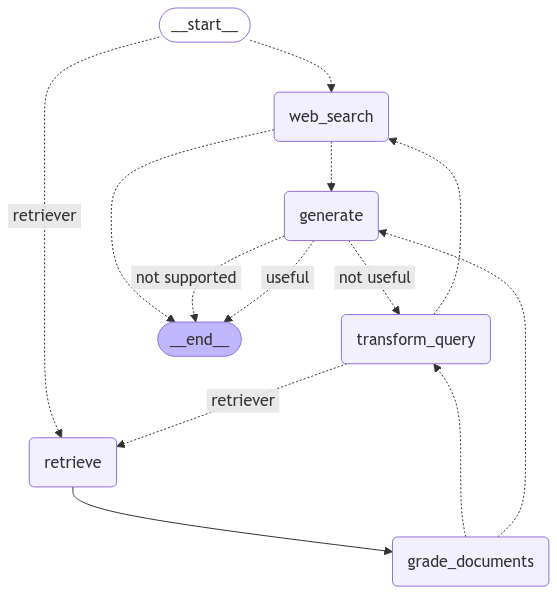

In [245]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [246]:
from pprint import pprint

# Run
inputs = {
    "question": "What number am I on the waitlist??"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
print("Output", value )
print(type(value))
print(value.get("generation", "Not found"))



# "question": "What are the class sizes for the lower and upper division classes under the engineering school?"
# "question": "What is UC Santa Cruz's grading policy for undergraduates?"
# "question": "How can I get a UC Santa Cruz catalog?"

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Documents added to sourceDocs
"Node 'generate':"
'\n---\n'
Output {'documents': Document(metadata={}, page_content='The status should say "Waiting" and next to it will be your position number.\nHow to Add to a Waitlist 2) Type in the 5-digit class number and click Enter, or find the class by conducting a Class Search. To add yourself to a wait list, the class must be full. • Click Enroll. • Click Add. If more than one quarter is available, select the quarter in which you are enrolling and click Continue. How to Add a Waitlist Page 1 of 4 Revised 07/6/2017 3) Select a section and click Next. 4) If the course is full and wait-list eligible, check the Waitlist if class is full checkbox. How to Add a Waitlist Revise

In [247]:
sourceDocs

[['The status should say "Waiting" and next to it will be your position number.\nHow to Add to a Waitlist 2) Type in the 5-digit class number and click Enter, or find the class by conducting a Class Search. To add yourself to a wait list, the class must be full. • Click Enroll. • Click Add. If more than one quarter is available, select the quarter in which you are enrolling and click Continue. How to Add a Waitlist Page 1 of 4 Revised 07/6/2017 3) Select a section and click Next. 4) If the course is full and wait-list eligible, check the Waitlist if class is full checkbox. How to Add a Waitlist Revised 7/6/2017 6) After you confirm your selection, click Finish Enrolling.\nIf I am on the waitlist for UCSC, what are my chances of being admitted? ... What number am I on the waitlist? We don\'t have a linear list of students\nI just got notified that I am waitlisted as a transfer student for the fall of 2020. I have a 3.9 gpa and i\'m a business & economics major.\nTo view your position on

In [236]:
document

[[Document(id='938b9a02-943d-495e-b422-75256da79506', metadata={'Index ': 57, 'gpt_prolog refactored': nan, 'gpt_prolog': '% Transfer Timeline for UC Santa Cruz\ntransfer_timeline([\n    first_year_community_college([\n        august([\n            research_major,\n            familiarize_transfer_requirements,\n            create_uc_transfer_admission_planner,\n            meet_with_representative_or_counselor_to_plan_tag\n        ]),\n        october_november([\n            apply_financial_aid(oct1_to_mar2),\n            campus_tour_or_event_attendance\n        ]),\n        march_august([\n            update_coursework_and_grades_in_tap\n        ])\n    ]),\n    second_year_community_college([\n        august([\n            meet_with_counselor_to_review_transfer_plan,\n            start_uc_application(august1)\n        ]),\n        september([\n            submit_tag_application(sept1_to_sept30)\n        ]),\n        october([\n            complete_submit_uc_application(oct1_to_dec2)

In [248]:
from pprint import pprint

# Run
inputs = {
    "question": "What are the class sizes for the lower and upper division classes under the engineering school?"
}

result = app.invoke(inputs)
print("Output" , result["generation"])


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Documents added to sourceDocs
Output Class sizes for lower division classes can range from 15 to 400 students, particularly for larger introductory courses. In contrast, upper division classes tend to be smaller, typically having fewer than 40 students. For specific class size data, you can refer to the Instructional Activity Dashboard at the provided link.


In [252]:
print(len(sourceDocs))
print(type(sourceDocs))
print(type(sourceDocs[0]))
print(type(sourceDocs[0][0]))
sourceDocs[1]

2
<class 'list'>
<class 'list'>
<class 'str'>


['To determine the class sizes for lower and upper division classes under the engineering school at UC Santa Cruz, you can refer to the Instructional Activity Dashboard provided by the Institutional Research, Analytics, and Planning Support (IRAPS). This dashboard provides detailed information on class sizes, including cross-listed classes, for different academic divisions and departments. Note that summer quarters are excluded from these calculations. You can access the dashboard for more detailed and specific data on class sizes on this website: https://iraps.ucsc.edu/iraps-public-dashboards/instructional-activity/class-sizes.html',
 'Varying Class Sizes\nClass size varies depending on the course. While most classes have fewer than 40 students, larger introductory classes may have anywhere from 15-400 students. Intro classes tend to have large class sizes while upper-division classes are smaller.']

In [84]:
# sourceDocs[0][0].page_content
sourceDocs

[[Document(id='9049482a-14a4-44d1-8123-cebf8cd381c9', metadata={'Index ': 18, 'gpt_prolog refactored': '% Dashboard Information for Class Sizes\nprovides_dashboard(iraps, "Instructional Activity Dashboard").\n\n% Purpose and Features of the Dashboard\ndashboard_info("Instructional Activity Dashboard", class_sizes).\ndashboard_feature("Instructional Activity Dashboard", includes_cross_listed_classes).\ndashboard_exclusion("Instructional Activity Dashboard", summer_quarters).\n\n% Scope of Data Available on the Dashboard\ndashboard_scope("Instructional Activity Dashboard", engineering_school).\ndashboard_scope("Instructional Activity Dashboard", lower_division_classes).\ndashboard_scope("Instructional Activity Dashboard", upper_division_classes).\n\n% Access to the Dashboard\ndashboard_access_link("Instructional Activity Dashboard", "https://iraps.ucsc.edu/iraps-public-dashboards/instructional-activity/class-sizes.html").\n\n% Rule for Checking Class Sizes\ncan_check_class_sizes(Student,

In [253]:
def get_final_answer(query):
    """
    Function to process a query and return the final answer using the RAG chain.
    
    Args:
        query (str): The query string to replace the placeholder question.

    Returns:
        str: The final answer from the RAG chain output.
    """

    inputs = {
    "question": query
}

    
    result = app.invoke(inputs)
    
    # Extract and return the final answer
    return result.get("generation", " ")


query = "What number am I on the waitlist??"
answer = get_final_answer(query)
print("Final Answer:", answer)


---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Documents added to sourceDocs
Final Answer: To find your position on the waitlist at UCSC, check the status of your waitlisted classes under "Class Schedule" in the left-navigation. Your position number will be displayed next to the status that says "Waiting." If you don't see this information, you may need to contact the registrar's office for assistance.


In [254]:
len(sourceDocs)

3

In [255]:
ucsc_qa_df = pd.read_csv("new_qa.csv", index_col=0)
ucsc_qa_df

,questions,answers,source_name,source,generated_response,source_docs
index,,,,,,
0,Who can be a member of the Boating Club?,Everyone is welcome to join! If you do not hav...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,Members of the Boating Club can include commun...,"Our club exists to give community members, UC ..."
1,What classes does the boating center offer to ...,We offer all levels of sailing (dinghy and kee...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The boating center offers classes for beginner...,UC Santa Cruz Community Boating Center is a co...
2,When is the boating club open?,"The club is open year-round, Saturday and Sund...",UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The boating club is open on Saturday and Sunda...,Boating Club Hours\nThe Community Boating Cent...
3,What boats are available to members?,Sailing vessels for weekend use currently incl...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,Members have access to the following sailing v...,Our boats:\nSailing vessels for weekend use cu...
4,How much does a boating membership cost?,UCSC Student Membership: $45\nNon-Student Quar...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The provided context does not include any info...,There are a few minor fees associated with tak...
...,...,...,...,...,...,...
107,What if I don't fulfill the general education ...,If you don't satisfy general education require...,Undergraduate Admissions FAQ,https://admissions.ucsc.edu/resources-support/...,If you do not complete the IGETC or partial IG...,"By the end of the fall term prior to transfer,..."
108,What is UC TAP?,UC Transfer Admission Planner (UC TAP) is an o...,Undergraduate Admissions FAQ,https://admissions.ucsc.edu/resources-support/...,"UC TAP, or the UC Transfer Admission Planner, ...",UCSC TPP\nUCSC TAG Step-by-Step\nComplete the ...
109,When are acceptance notices sent out?,"For fall quarter acceptance, notices are sent ...",Undergraduate Admissions FAQ,https://admissions.ucsc.edu/resources-support/...,The context does not specify when acceptance n...,First Year\t\nApplication Submission\n\nMay 20...


In [256]:
agentic_rag_answers = []
count = 0
sourceDocs.clear()
for question in ucsc_qa_df['questions']:
    print(f"Processing question: {question}")
    count += 1
    print(f"Question count: {count}")
    answer = get_final_answer(question)
    agentic_rag_answers.append(answer)

Processing question: Who can be a member of the Boating Club?
Question count: 1
---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Documents added to sourceDocs
Processing question: What classes does the boating center offer to community members?
Question count: 2
---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCI

In [257]:

print(len(agentic_rag_answers))
print(count)
print(len(sourceDocs))

112
112
101


In [258]:
numbers = [9, 13, 25, 33, 43 ,53 , 66, 74 , 75 , 80 , 91] 

for i in numbers:
    print(f"Question: {ucsc_qa_df['questions'][i-1]}")
    print(f"Orginal Answer: {ucsc_qa_df['answers'][i-1]}")
    print(f"Answer: {agentic_rag_answers[i-1]}")
    print("\n")


Question: Do the boating club rent Kayaks?
Orginal Answer: We do not rent our kayaks out to members. Kayak Connection is the place to go to rent a kayak in the Harbor.
Answer: Yes, the UCSC Boating Club offers kayak rental services for both students and community members. They aim to connect individuals to the Monterey Bay through various recreational activities, including kayaking. For more information, you can visit their website.


Question: How do I get my UC SHIP ID card?
Orginal Answer: Insurance ID cards are electronic. Download the Sydney Health app to access your ID card; find Student Health Center location, hours and services; view medical, pharmacy, dental and vision coverage and claims information; and get notifications for benefit changes and action items.
If you would like a hard copy of your insurance ID card then contact UC SHIP Member Services at 1-866-940-8306.
Answer:  


Question: Which residential college is best for incoming engineering students?
Orginal Answer: E

In [55]:
for i, q in enumerate(ucsc_qa_df['questions']):
    if q == "Does UCSC have a waitlist?":
        print(ucsc_qa_df['answers'][i])

Yes. UCSC offers a number of denied first-year students the opportunity to be considered on a waitlist. For more information on the waitlist process, please see the FAQ below.
Yes, UCSC uses a waitlist for fall quarter admission. 


In [56]:
for i, q in enumerate(ucsc_qa_df['questions']):
    if q == "When are acceptance notices sent out?":
        print(ucsc_qa_df['answers'][i])

For fall quarter acceptance, most notices are sent late February through March 20 for first-year students and April 1-30 for transfer students. For winter quarter acceptance, notices are sent out on approximately September 15 of the previous year.
For fall quarter acceptance, notices are sent April 1-30 for enrollment that fall. For winter quarter acceptance, notices are sent September 15 for enrollment the following winter.


In [52]:
import collections
collections.Counter(ucsc_qa_df['questions'])

Counter({'Does UCSC have a waitlist?': 2,
         'When are acceptance notices sent out?': 2,
         'Who can be a member of the Boating Club?': 1,
         'What classes does the boating center offer to community members?': 1,
         'When is the boating club open?': 1,
         'What boats are available to members?': 1,
         'How much does a boating membership cost?': 1,
         'How do I sign up for a boating membership?': 1,
         'How can I join the Boating Club?': 1,
         'Are there additional fees to take out the boats after I join the boating club?': 1,
         'Do the boating club rent Kayaks?': 1,
         'How can I get involved with the Boating Club?': 1,
         'Why is health insurance required at UCSC?': 1,
         'How do I get UC SHIP?': 1,
         'How do I get my UC SHIP ID card?': 1,
         'Am I eligible if I opted out of UC SHIP last year?': 1,
         "Am I eligible for UC SHIP if I've graduated? ": 1,
         'How much does UC SHIP cost?

In [ ]:
src_ans_list = ucsc_qa_df['answers'].tolist()
src_questions = ucsc_qa_df['questions'].tolist()
gen_ans_list = agentic_rag_answers


indexes_to_remove = [9, 13, 25, 33, 43 ,53 , 66, 74 , 75 , 80 , 91] 

# Convert to 0-based indexes
zero_based_indexes = {i - 1 for i in indexes_to_remove}

# Remove elements at these indexes
src_ans_list = [ans for i, ans in enumerate(src_ans_list) if i not in zero_based_indexes]
src_questions = [ques for i, ques in enumerate(src_questions) if i not in zero_based_indexes]
gen_ans_list = [gen_ans for i, gen_ans in enumerate(gen_ans_list) if i not in zero_based_indexes]

In [260]:
len(sourceDocs), type(sourceDocs)

(101, list)

In [147]:
type(sourceDocs[0])

list

In [261]:
print(len(src_ans_list), len(gen_ans_list), len(src_questions), len(sourceDocs))

101 101 101 101


In [56]:
type(sourceDocs[0][0])

langchain_core.documents.base.Document

In [40]:
src_docs_new = []
for docs in sourceDocs:
    src_docs_new.append(str(docs.page_content))

In [ ]:
# import os
# from datasets import Dataset
# from ragas import evaluate
# from ragas.metrics import (
#     faithfulness,
#     answer_relevancy,
#     context_recall,
#     context_precision,
# )

# data = {
#     "question": src_questions,
#     "ground_truth": src_ans_list,
#     "answer": gen_ans_list,
#     "retrieved_contexts": sourceDocs,
# }
# dataset = Dataset.from_dict(data)

# metrics = [faithfulness, answer_relevancy, context_recall, context_precision]

# results = evaluate(dataset, metrics=metrics, raise_exceptions=False)


# results_df = results.to_pandas()

# # Display the evaluation results
# print(results_df)

Evaluating: 100%|██████████| 404/404 [03:01<00:00,  2.23it/s]


                                            user_input  \
0             Who can be a member of the Boating Club?   
1    What classes does the boating center offer to ...   
2                       When is the boating club open?   
3                 What boats are available to members?   
4             How much does a boating membership cost?   
..                                                 ...   
96   What if I don't fulfill the general education ...   
97                                     What is UC TAP?   
98               When are acceptance notices sent out?   
99   What are the Cross-Campus and Simultaneous Enr...   
100    Can I talk to an adviser during a campus visit?   

                                    retrieved_contexts  \
0    [How can I join the Boating Club?, The boating...   
1    [UC Santa Cruz Community Boating Center is a c...   
2    [Boating Club Hours\nThe Community Boating Cen...   
3    [Our boats:\nSailing vessels for weekend use c...   
4    [Boating

In [263]:
average_scores = results_df[['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']].mean()

# Display the average scores
print("Average Scores:")
print(average_scores)

Average Scores:
faithfulness         0.789722
answer_relevancy     0.871394
context_recall       0.478194
context_precision    0.754950
dtype: float64


In [264]:
import pandas as pd


# Create a dictionary with column names as keys
data = {
    'Source Answers': src_ans_list,
    'Generated Answers': gen_ans_list,
    'Source Questions': src_questions,
    'Source Documents': sourceDocs
}

# Convert dictionary to a DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV file
df.to_csv('AdaptiveRAGoutput_file.csv', index=False)

print("CSV file has been saved successfully.")


CSV file has been saved successfully.
